# Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import sys
import warnings

sys.path.append("..")
from utils import *
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

%matplotlib inline

# Data import

## Antibody pairs

In [2]:
antibody_pairs = pd.read_csv(os.path.dirname(os.getcwd()) + "/data/antibody_pairs/Antibody_pairs.csv")

In [3]:
cluster_comparison_default = pd.read_csv(os.path.dirname(os.getcwd()) + 
    "/data/antibody_pairs/Antibody_pairs_cluster_comparison.csv")
cluster_comparison_default[:5]

,Epitope_ID_A,Epitope_ID_B,Clone_ID_A,Clone_ID_B,IGX_A,IGX_B,IGX_clustered,SAABplus_A,SAABplus_B,SAABplus_clustered,SPACE2_A,SPACE2_B,SPACE2_length_A,SPACE2_length_B,SPACE2_clustered,SPACE2_clustered_length
0,164067,164069,bf226286707d82bda728cbef30375ccd358dc00fd3d175...,3302c6ccef79e396bf79043b81511f50c70bd7c476e560...,1328,1328,True,1yymR,1yymR,True,1710,1710,13_10_21_11_8_11,13_10_21_11_8_11,True,True
1,164078,164079,ad5b550aabf130663ecc53fb708035fdb1ac5c34e1096b...,6503ec1e63c6319e7adc1227f4302ed2d618a15dbc81c1...,1354,1354,True,3macH,3macH,True,263,263,13_10_14_11_8_11,13_10_14_11_8_11,True,True
2,969166,969167,2c6b76f8abeb2ae2cdba29efdd2096543d816cb5409b99...,9501c71df16e2728f9d63f1c999700760b7f43d20db86c...,5853,5853,True,4nrxH,4nrxH,True,5701,5701,14_9_23_11_8_12,14_9_23_11_8_12,True,True
3,969166,969168,2c6b76f8abeb2ae2cdba29efdd2096543d816cb5409b99...,24b1f7f80b240d6eb281a80900f0f2637f1aa8164a4060...,5853,5853,True,4nrxH,4nrxH,True,5701,5701,14_9_23_11_8_12,14_9_23_11_8_12,True,True
4,969167,969168,9501c71df16e2728f9d63f1c999700760b7f43d20db86c...,24b1f7f80b240d6eb281a80900f0f2637f1aa8164a4060...,5853,5853,True,4nrxH,4nrxH,True,5701,5701,14_9_23_11_8_12,14_9_23_11_8_12,True,True


## ID mapping

In [4]:
epitope_clone_mapping = pd.read_csv(os.path.dirname(os.getcwd()) + 
    "/data/antibody_pairs/Epitope_PDB_clone_ID.csv")

## IGX-Cluster

In [5]:
# load all IGX CLuster datasets and save in dictionary
igx_dict = {}
igx_dict["V_J_80"] = pd.read_csv(os.path.dirname(os.getcwd()) + "/data/clustering/IGX_Cluster_clustering.tsv", sep="\t",
     low_memory=False)
igx_dict["V_80"] = pd.read_csv(os.path.dirname(os.getcwd()) + "/data/clustering/IGX_Cluster_clustering_V_80.tsv", sep="\t",
     low_memory=False)
igx_dict["V_J_70"] = pd.read_csv(os.path.dirname(os.getcwd()) + "/data/clustering/IGX_Cluster_clustering_V_J_70.tsv", sep="\t",
     low_memory=False)
igx_dict["V_70"] = pd.read_csv(os.path.dirname(os.getcwd()) + "/data/clustering/IGX_Cluster_clustering_V_70.tsv", sep="\t",
     low_memory=False)

# preprocess datasets
for i in igx_dict.keys():
    igx_dict[i] = preprocess_IGX_data(igx_dict[i])

Germline sequences: 10197
Unique clones: 10490
Germline sequences: 10166
Unique clones: 10490
Germline sequences: 8302
Unique clones: 10490
Germline sequences: 7897
Unique clones: 10490


## SAAB+ clusters

In [6]:
saabplus = pd.read_csv(os.path.dirname(os.getcwd()) + "/data/clustering/SAABplus_clustering_heavy_chains.tsv", 
    sep="\t", index_col=0)
print("Number of SAAB+ clones:", len(saabplus))

Number of SAAB+ clones: 10402


## SPACE2 clusters

In [7]:
space2 = pd.read_csv(os.path.dirname(os.getcwd()) + "/data/clustering/SPACE2_clustering.csv")
space2.rename(columns={"ID":"Clone_ID"}, inplace=True)
print("Number of SPACE2 clones:", len(space2))

Number of SPACE2 clones: 10489


In [8]:
space2_dict = {}
cutoffs = ["1", "1_5", "2", "2_5"]

# load and preprocess all SPACE2 cluster datasets and save in dictionary
for cutoff in cutoffs:
    space2_dict[cutoff] = load_SPACE2_data("SPACE2_clustering_cutoff_" + cutoff, 
        os.path.dirname(os.getcwd()) + "/data/clustering/")
    space2_dict[cutoff] = preprocess_SPACE2_data(space2_dict[cutoff])

# Preprocessing

## SAAB+

In [9]:
saabplus_clustered = saabplus[saabplus["Clusters"] != "None"]
saabplus_unclustered = saabplus[saabplus["Clusters"] == "None"]

In [10]:
clones_seq = igx_dict["V_J_80"][["Unique Clone Id", "Receptor Amino Acids"]]
clones_seq.columns = ["Clone_ID", "Protein_Seq"]

# add clone ID to dataset by merging on protein sequence
saabplus_clustered_clones = clones_seq.merge(saabplus_clustered, on="Protein_Seq")
saabplus_clustered_clones[:5]

,Clone_ID,Protein_Seq,CDR-H3_template,Redundancy,Framework_template,CDR-H3_sequence,ESS,Annotation,H1_Canonical_Class,H2_Canonical_Class,Clusters
0,0000eb36a7bfc7221b2eccb84e146f2373199391d1a442...,VESGGGLVQPGGSLRLSCAASGFAFSSYSMSWVRQAPGKGLEWVSY...,4jqiH,1,6apcH,ARERQQLWVDLNY,39,False,H1-8-A,H2-8-B,4jqiH
1,055f5871b36438624fb23e7676ec3e36c6127d985c546f...,VESGGGLVQPGGSLRLSCAASGFTFSSYSMSWVRQAPGKGLEWVSY...,NaN,1,6apcH,AREGNYNFWSGCYDPDFDN,0,False,H1-8-A,H2-8-B,NaN
2,0e5c373c06e5cff7d726e9767d08f00f1affd537c4ed32...,VESGGGLVQPGGSLRLSCAASGFTFSSYSMNWVRQAPGKGLEWVSY...,6al4F,1,6apcH,ARDGITIFGVVIIPVDY,38,False,H1-8-A,H2-8-B,6al4F
3,10ff1b5baf4d3120e870cf25447433e265c08d884060e6...,VESGGGLVQPGGSLRLSCAASGFTFSSYEMNWVQQAPGKGLEWVSY...,2adfH,1,6apcH,ARHNPLYYFDY,60,True,H1-8-A,H2-8-B,3cleH
4,191738826b551307699108db34ae2cc2b3c7d8887f65f0...,VESGGGLVQPGGSLRLSCAASGFTFSSYEMNWVRQAPGKGLEWVSY...,5e94B,1,6apcH,AREGSDFWSGYYTPDY,48,False,H1-8-A,H2-8-B,5e94B


## SPACE2

In [11]:
# create integer mapping for unique strings
integer_mapping = {string: i for i, string in enumerate(space2["cluster_by_rmsd"].unique())}
# replace strings with integers 
space2["cluster_by_rmsd"] = space2["cluster_by_rmsd"].map(integer_mapping)

# extract ID from path string
space2["Clone_ID"] = space2["Clone_ID"].apply(rename_ID)

# Random clustering success rate

## Get cluster sizes for each clustering approach

In [12]:
igx_cluster_sizes = igx_dict["V_J_80"]["Unique Cluster Id"].value_counts().to_list()
print("Number of IGX-Cluster clusters:", len(igx_cluster_sizes))
print("Sum of IGX-Cluster clusters:", sum(igx_cluster_sizes))
print("Unique:", igx_dict["V_J_80"]["Unique Clone Id"].is_unique)
print("")

space2_cluster_sizes = space2["cluster_by_rmsd"].value_counts().to_list()
print("Number of SPACE2 clusters:", len(space2_cluster_sizes))
print("Sum of SPACE2 clusters:", sum(space2_cluster_sizes))
print("Unique:", space2["Clone_ID"].is_unique)
print("")

saabplus_cluster_sizes = saabplus_clustered_clones["Clusters"].value_counts().to_list()
print("Number of SAAB+ clusters:", len(saabplus_cluster_sizes))
print("Sum of  SAAB+ clusters:", sum(saabplus_cluster_sizes))
print("Unique:", saabplus_clustered_clones["Clone_ID"].is_unique)

Number of IGX-Cluster clusters: 10197
Sum of IGX-Cluster clusters: 10490
Unique: True

Number of SPACE2 clusters: 8031
Sum of SPACE2 clusters: 10489
Unique: True

Number of SAAB+ clusters: 973
Sum of  SAAB+ clusters: 9100
Unique: True


## Clustered antibody pairs

In [13]:
cluster_comparison = antibody_pairs[["Epitope_ID_A", "Epitope_ID_B"]]
cluster_comparison["Clone_ID_A"] = cluster_comparison["Epitope_ID_A"].apply(add_clone_id, args=[epitope_clone_mapping])
cluster_comparison["Clone_ID_B"] = cluster_comparison["Epitope_ID_B"].apply(add_clone_id, args=[epitope_clone_mapping])
cluster_comparison.dropna(subset=["Clone_ID_A", "Clone_ID_B"], inplace=True)

### IGX-Cluster

In [14]:
for i, setting in enumerate(igx_dict.keys()):
    
    cluster = igx_dict[setting]
    column_A = "IGX_A_" + str(setting)
    column_B = "IGX_B_" + str(setting)
            
    cluster_comparison[column_A] = cluster_comparison["Clone_ID_A"].apply(add_cluster, args=[cluster, "Unique Clone Id", 
    "Unique Cluster Id"])
    cluster_comparison[column_B] = cluster_comparison["Clone_ID_B"].apply(add_cluster, args=[cluster, "Unique Clone Id", 
        "Unique Cluster Id"])
    cluster_comparison["IGX_clustered_" + str(setting)] = np.where(cluster_comparison[column_A] == cluster_comparison[column_B], True, False)
    print(cluster_comparison["IGX_clustered_" + str(setting)].value_counts())

IGX_clustered_V_J_80
False    189
True      24
Name: count, dtype: int64
IGX_clustered_V_80
False    187
True      26
Name: count, dtype: int64
IGX_clustered_V_J_70
False    164
True      49
Name: count, dtype: int64
IGX_clustered_V_70
False    144
True      69
Name: count, dtype: int64


### SPACE2

In [15]:
for i, cutoff in enumerate(space2_dict.keys()):
    
    cluster = space2_dict[cutoff]
    column_A = "SPACE2_A_" + str(cutoff)
    column_B = "SPACE2_B_" + str(cutoff)
            
    cluster_comparison[column_A] = cluster_comparison["Clone_ID_A"].apply(add_cluster, args=[cluster, "Clone_ID", 
    "cluster_by_rmsd"])
    cluster_comparison[column_B] = cluster_comparison["Clone_ID_B"].apply(add_cluster, args=[cluster, "Clone_ID", 
        "cluster_by_rmsd"])
    cluster_comparison["SPACE2_clustered_" + str(cutoff)] = np.where(cluster_comparison[column_A] == cluster_comparison[column_B], True, False)
    print(cluster_comparison["SPACE2_clustered_" + str(cutoff)].value_counts())

SPACE2_clustered_1
False    202
True      11
Name: count, dtype: int64
SPACE2_clustered_1_5
False    197
True      16
Name: count, dtype: int64
SPACE2_clustered_2
False    195
True      18
Name: count, dtype: int64
SPACE2_clustered_2_5
False    193
True      20
Name: count, dtype: int64


## Compare random clustering rates

In [16]:
pal = sns.color_palette(palette="Set2")
pal

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [17]:
cluster_rate_igx = pd.read_csv(os.path.dirname(os.getcwd()) + 
    "/data/Random_clustering_rates/Random_clustering_rates_IGX.csv")
cluster_rate_space2 = pd.read_csv(os.path.dirname(os.getcwd()) + 
    "/data/Random_clustering_rates/Random_clustering_rates_SPACE2.csv")
cluster_rate_saabplus = pd.read_csv(os.path.dirname(os.getcwd()) + 
    "/data/Random_clustering_rates/Random_clustering_rates_SAABplus.csv")

In [18]:
cluster_rate_igx["Method"] = "IGX-Cluster"
cluster_rate_space2["Method"] = "SPACE2"
cluster_rate_saabplus["Method"] = "SAAB+"

cluster_rates = pd.concat([cluster_rate_igx, cluster_rate_saabplus, cluster_rate_space2, ])

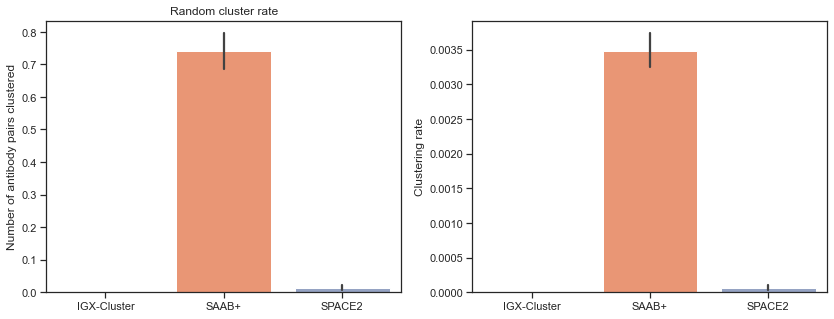

In [19]:
sns.set(style=("ticks"), font_scale=1, palette="Set2")
fig, ax = plt.subplots(1, 2, figsize=(14,5))

sns.barplot(data=cluster_rates, x="Method", y="Clustered_count", palette="Set2", ax=ax[0])
ax[0].set(title="Random cluster rate", xlabel=None, ylabel="Number of antibody pairs clustered")
sns.barplot(data=cluster_rates, x="Method", y="Clustering_rate", palette="Set2", ax=ax[1])
ax[1].set(xlabel=None, ylabel="Clustering rate");

### IGX Cluster settings

In [20]:
cluster_rate_V_J_80 = pd.read_csv(os.path.dirname(os.getcwd()) + 
    "/data/Random_clustering_rates/Random_clustering_rates_IGX.csv")
cluster_rate_V_80 = pd.read_csv(os.path.dirname(os.getcwd()) + 
    "/data/Random_clustering_rates/Random_clustering_rates_IGX_V_80.csv")
cluster_rate_V_J_70 = pd.read_csv(os.path.dirname(os.getcwd()) + 
    "/data/Random_clustering_rates/Random_clustering_rates_IGX_V_J_70.csv")
cluster_rate_V_70 = pd.read_csv(os.path.dirname(os.getcwd()) + 
    "/data/Random_clustering_rates/Random_clustering_rates_IGX_V_70.csv")

In [21]:
cluster_rate_V_J_80["Setting"] = "V_J_80"
cluster_rate_V_80["Setting"] = "V_80"
cluster_rate_V_J_70["Setting"] = "V_J_70"
cluster_rate_V_70["Setting"] = "V_70"

cluster_rates_igx = pd.concat([cluster_rate_V_J_80, cluster_rate_V_80, cluster_rate_V_J_70, cluster_rate_V_70])

In [22]:
clustered_igx = cluster_comparison[["IGX_clustered_V_J_80", "IGX_clustered_V_80", "IGX_clustered_V_J_70", 
    "IGX_clustered_V_70"]]

### SPACE2 RMSD thresholds

In [23]:
cluster_rate_1 = pd.read_csv(os.path.dirname(os.getcwd()) + 
    "/data/Random_clustering_rates/Random_clustering_rates_SPACE2_1.csv")
cluster_rate_1_5 = pd.read_csv(os.path.dirname(os.getcwd()) + 
    "/data/Random_clustering_rates/Random_clustering_rates_SPACE2_1_5.csv")
cluster_rate_2 = pd.read_csv(os.path.dirname(os.getcwd()) + 
    "/data/Random_clustering_rates/Random_clustering_rates_SPACE2_2.csv")
cluster_rate_2_5 = pd.read_csv(os.path.dirname(os.getcwd()) + 
    "/data/Random_clustering_rates/Random_clustering_rates_SPACE2_2_5.csv")

In [24]:
cluster_rate_1["Cutoff"] = "1"
cluster_rate_1_5["Cutoff"] = "1.5"
cluster_rate_2["Cutoff"] = "2"
cluster_rate_2_5["Cutoff"] = "2.5"

cluster_rates_space2 = pd.concat([cluster_rate_1, cluster_rate_1_5, cluster_rate_2, cluster_rate_2_5])

In [25]:
clustered_space2= cluster_comparison[["SPACE2_clustered_1", "SPACE2_clustered_1_5", "SPACE2_clustered_2", 
    "SPACE2_clustered_2_5"]]

## Combined

In [26]:
cluster_comparison_default.columns
clustered_default = cluster_comparison_default[["IGX_clustered", "SAABplus_clustered", "SPACE2_clustered"]]

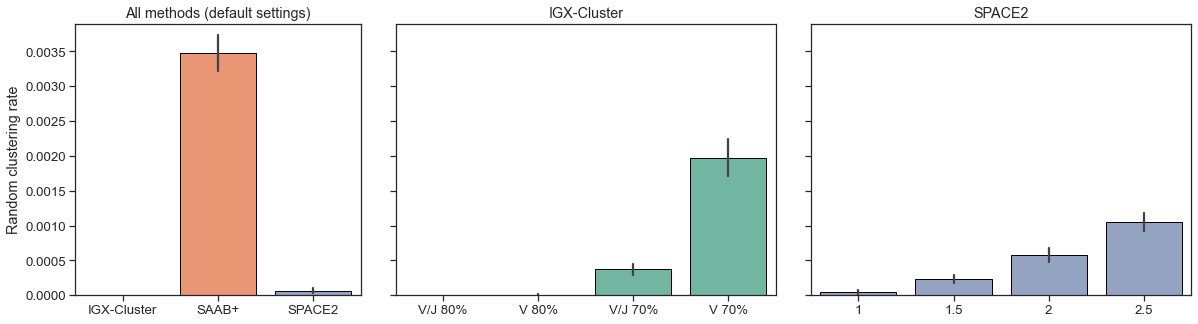

In [27]:
sns.set(style=("ticks"), font_scale=1.2, palette="Set2")
fig, ax = plt.subplots(1, 3, figsize=(20,5), width_ratios=[3, 4, 4], sharey=True)
plt.subplots_adjust(wspace=0.1)

sns.barplot(data=cluster_rates, x="Method", y="Clustering_rate", palette="Set2", edgecolor="k", ax=ax[0])
ax[0].set(title="All methods (default settings)", xlabel=None, ylabel="Random clustering rate", ylim=(0,0.0039))

sns.barplot(data=cluster_rates_igx, x="Setting", y="Clustering_rate", color=pal[0], edgecolor="k", ax=ax[1])
ax[1].set(title="IGX-Cluster", xlabel=None, ylabel=None, ylim=(0,0.0039))
ax[1].set_xticks(ticks=[0,1,2,3], labels=["V/J 80%", "V 80%", "V/J 70%", "V 70%"])

sns.barplot(data=cluster_rates_space2, x="Cutoff", y="Clustering_rate", color=pal[2], edgecolor="k", ax=ax[2])
ax[2].set(title="SPACE2", xlabel=None, ylabel=None, ylim=(0,0.0039))

plt.savefig(os.path.dirname(os.getcwd()) + "/figs/Random_clustering_rate.png", dpi=300, 
    transparent=True, bbox_inches="tight")

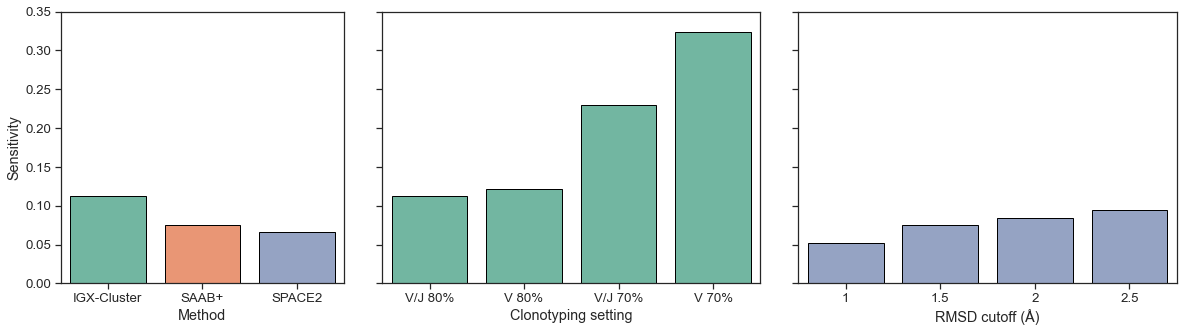

In [28]:
sns.set(style=("ticks"), font_scale=1.2, palette="Set2")
fig, ax = plt.subplots(1, 3, figsize=(20,5), width_ratios=[3, 4, 4], sharey=True)
plt.subplots_adjust(wspace=0.11)

sns.barplot(x=["IGX-Cluster", "SAAB+", "SPACE2"], y=clustered_default.sum(axis=0).values / len(cluster_comparison_default), 
    palette="Set2", edgecolor="k", ax=ax[0]) 
ax[0].set(xlabel="Method", ylabel="Sensitivity", ylim=(0,0.35))

sns.barplot(x=["V_J_80", "V_80", "V_J_70", "V_70"], y=clustered_igx.sum(axis=0).values / len(cluster_comparison), 
    color=pal[0], edgecolor="k", ax=ax[1])
ax[1].set(xlabel="Clonotyping setting", ylim=(0,0.35))
ax[1].set_xticks(ticks=[0,1,2,3], labels=["V/J 80%", "V 80%", "V/J 70%", "V 70%"])

sns.barplot(x=["1", "1.5", "2", "2.5"], y=clustered_space2.sum(axis=0).values / len(cluster_comparison), 
    color=pal[2], edgecolor="k", ax=ax[2])
ax[2].set(xlabel="RMSD cutoff (Å)", ylim=(0,0.35))

plt.savefig(os.path.dirname(os.getcwd()) + "/figs/Sensitivity.png", dpi=300, 
    transparent=True, bbox_inches="tight")

# False positives

In [29]:
cluster_dict = {}
# loop over clusters of antibody pair dataset
for i in range(12):
    antibody_pairs_cluster = antibody_pairs[antibody_pairs["Cluster"] == i]
    antibody_cluster_epitope_ids = set(antibody_pairs_cluster["Epitope_ID_A"]).union(set(antibody_pairs_cluster["Epitope_ID_B"]))
    cluster_dict[i] = antibody_cluster_epitope_ids

## IGX-Cluster

In [30]:
# check for false positive pairs across different IGX clonotyping settings
for i, setting in enumerate(igx_dict.keys()):
    
    print(setting)
    igx = igx_dict[setting]
    
    clone_count = igx["Unique Cluster Id"].value_counts()
    multi_clone_clusters = clone_count[clone_count > 1].index

    multi_clone_igx = igx[igx["Unique Cluster Id"].isin(multi_clone_clusters)]
    print("Number of multi-clone clusters:", len(multi_clone_igx["Unique Cluster Id"].unique()))
    
    all_pairs = []
    
    for cluster in multi_clone_clusters:

        current_cluster = multi_clone_igx[multi_clone_igx["Unique Cluster Id"] == cluster]["Unique Clone Id"].values
        false_positive_pairs = check_for_wrong_pairs_in_clusters(current_cluster, epitope_clone_mapping, cluster_dict)
        if false_positive_pairs != []:
            all_pairs.extend(false_positive_pairs)
            
    print(all_pairs)

V_J_80
Number of multi-clone clusters: 227
[]
V_80
Number of multi-clone clusters: 245
[]
V_J_70
Number of multi-clone clusters: 808
[]
V_70
Number of multi-clone clusters: 819
[]


## SPACE2

In [31]:
# check for false positive pairs across different SPACE2 cutoffs
for i, cutoff in enumerate(space2_dict.keys()):
    
    print(cutoff)
    space2 = space2_dict[cutoff]
    
    clone_count = space2["cluster_by_rmsd"].value_counts()
    multi_clone_clusters = clone_count[clone_count > 1].index

    multi_clone_space2 = space2[space2["cluster_by_rmsd"].isin(multi_clone_clusters)]
    print("Number of multi-clone clusters:", len(multi_clone_space2["cluster_by_rmsd"].unique()))
    
    all_pairs = []
    
    for cluster in multi_clone_clusters:

        current_cluster = multi_clone_space2[multi_clone_space2["cluster_by_rmsd"] == cluster]["Clone_ID"].values
        false_positive_pairs = check_for_wrong_pairs_in_clusters(current_cluster, epitope_clone_mapping, cluster_dict)
        if false_positive_pairs != []:
            all_pairs.extend(false_positive_pairs)
            
    print(all_pairs)

1
Number of multi-clone clusters: 753
[]
1_5
Number of multi-clone clusters: 1930
[]
2
Number of multi-clone clusters: 1917
[]
2_5
Number of multi-clone clusters: 1562
[]
